In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import datetime
import os

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp

# Lotka-Voltera 2 populations - Holling 1

## Sampled data

In [8]:
from utils.models_catalogue import lv_model_2pop_derivatives, eco_to_dimless_2pop

# Parameters of the simulation
t_max = 100
nb_point = 60
data_noise_intensity = 0.08
noise_seed = 111

# Parameters of the dynamics
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref
X_ini = [1, 1] # Predator, Prey


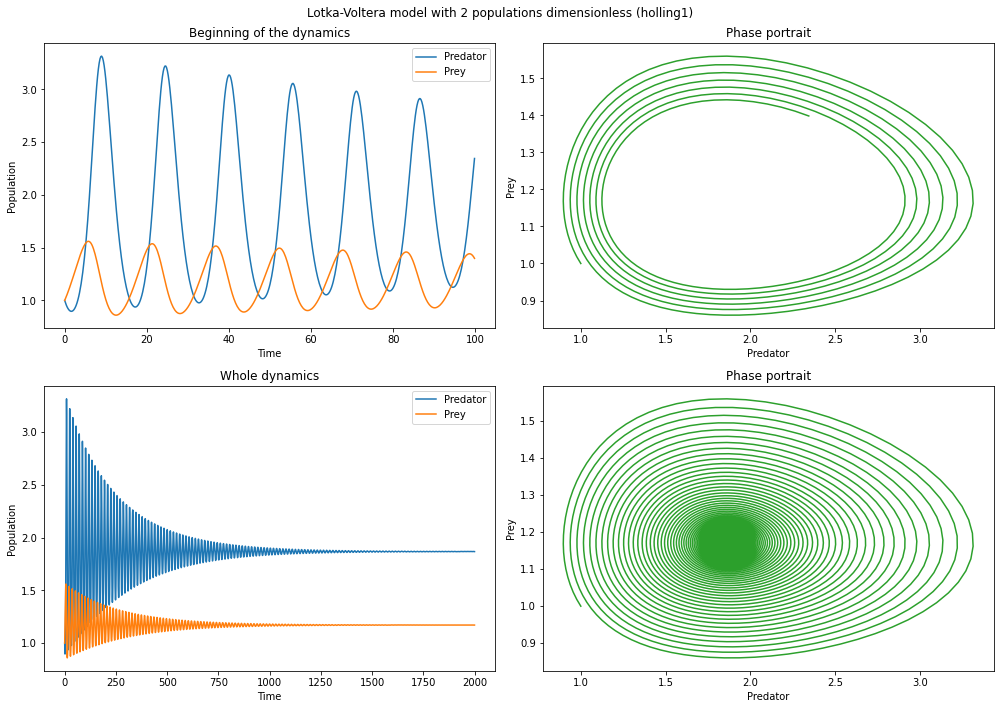

In [9]:
# Plot the dynamics
t_simu = np.linspace(0, 2000, 10000)
X_simu = odeint(lv_model_2pop_derivatives, X_ini, t_simu, args=(dimless_params_2pop, ), atol=1e-8, rtol=1e-11)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
idx_max = 500
axs[0, 0].plot(t_simu[:idx_max], X_simu[:idx_max])
axs[0, 0].set_xlabel("Time") ; axs[0, 0].set_ylabel("Population")
axs[0, 0].set_title("Beginning of the dynamics")
axs[0, 0].legend(["Predator", "Prey"])
axs[0, 1].plot(X_simu[:idx_max, 0], X_simu[:idx_max, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[0, 1].set_xlabel("Predator")
axs[0, 1].set_ylabel("Prey")
axs[0, 1].set_title("Phase portrait")
axs[1, 0].plot(t_simu, X_simu)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Population")
axs[1, 0].set_title("Whole dynamics")
axs[1, 0].legend(["Predator", "Prey"])
axs[1, 1].plot(X_simu[:, 0], X_simu[:, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[1, 1].set_xlabel("Predator")
axs[1, 1].set_ylabel("Prey")
axs[1, 1].set_title("Phase portrait")

plt.suptitle("Lotka-Voltera model with 2 populations dimensionless ("+dimless_params_2pop["func_resp"]+")")
plt.tight_layout()
plt.show()

* * * * Sampled data * * * *
Number of points: 60
Noise intensity: 0.08


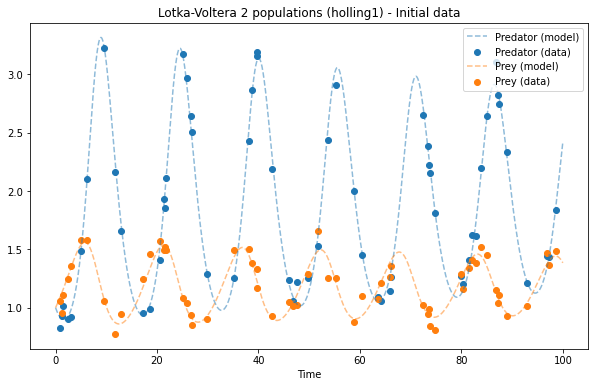

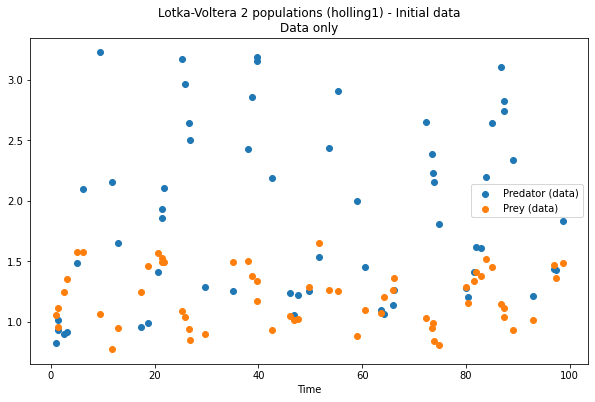

In [10]:
# Data generation
datagen_LV2 = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")
sample_plan_LV2 = sp.sample_plan(tmax=t_max, nbpoint=nb_point, plan_type="random")
print("* * * * Sampled data * * * *")
print("Number of points:", nb_point)
print("Noise intensity:", data_noise_intensity)
plt.figure(figsize=(10, 6))
datagen_LV2.get_data(plan=sample_plan_LV2, noise_intensity=data_noise_intensity, noise_seed=noise_seed, 
                       plot_data=True, permissible_range=[0, np.inf], default_value=0)
plt.show()
plt.figure(figsize=(10, 6))
datagen_LV2.plot_initial_data(elements_to_plot=["data"], title=datagen_LV2.model_name+" - Initial data"+"\nData only")

In [11]:
fitted_params = ['kappa_tild', 'Tr1_tild', 'Tr2_tild', 'Tc_tild', 'Ta_tild', 'lambda_tild']
# fitted_params = ['Tr1_tild', 'Tr2_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.3)) \
                              for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}


from tabulate import tabulate
table = []
for key in dimless_params_2pop.keys():
    real_value = dimless_params_2pop.get(key, "-")
    initial_value = dimless_params_2pop_fitted.get(key, "-")
    table.append([key, "{:.3f}".format(real_value) if isinstance(real_value, float) else real_value, 
                  "{:.3f}".format(initial_value) if isinstance(initial_value, float) else initial_value])
print(tabulate(table, headers=["Parameter", "Real Value", "Initial Fitted Value"], tablefmt="grid"))


+-------------+--------------+------------------------+
| Parameter   | Real Value   | Initial Fitted Value   |
+=============+==============+========================+
| kappa_tild  | 0.031        | 0.007                  |
+-------------+--------------+------------------------+
| Tr1_tild    | 11.364       | 13.586                 |
+-------------+--------------+------------------------+
| Tr2_tild    | 50.000       | 34.527                 |
+-------------+--------------+------------------------+
| Tc_tild     | 13.310       | 13.321                 |
+-------------+--------------+------------------------+
| Ta_tild     | 96.899       | 132.526                |
+-------------+--------------+------------------------+
| lambda_tild | 0.652        | 0.661                  |
+-------------+--------------+------------------------+
| func_resp   | holling1     | -                      |
+-------------+--------------+------------------------+
| Tref        | 10           | -                

In [12]:
# Plot the dynamics
t_simu_adapt = np.linspace(0, t_max, 500)
X_simu_real = odeint(lv_model_2pop_derivatives, X_ini, t_simu_adapt, args=(dimless_params_2pop, ), atol=1e-8, rtol=1e-11)
dimless_params_2pop_ini = {**dimless_params_2pop_fixed, **dimless_params_2pop_fitted}
X_simu_ini = odeint(lv_model_2pop_derivatives, X_ini, t_simu_adapt, args=(dimless_params_2pop_ini, ), atol=1e-8, rtol=1e-11)



defaut_color = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(10, 6))
plt.plot(t_simu_adapt, X_simu_real[:, 0], label="Real - predator", color=defaut_color[0], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_real[:, 1], label="Real - prey", color=defaut_color[1], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_ini[:, 0], label="Initial - predator", color=defaut_color[0])
plt.plot(t_simu_adapt, X_simu_ini[:, 1], label="Initial - prey", color=defaut_color[1])
plt.scatter(datagen_LV2.t_samples[0], datagen_LV2.states_data_noisy[0], color=defaut_color[0], label="Data - predator")
plt.scatter(datagen_LV2.t_samples[1], datagen_LV2.states_data_noisy[1], color=defaut_color[1], label="Data - prey")
plt.xlabel("Time") ; plt.ylabel("Population")
plt.title("Initialise before training")
plt.legend()
plt.show()

## Test the NN architecture

Directory created at: outputs/LV2_holing1-example/20240304_001321-all_params
Path for export: outputs/LV2_holing1-example/20240304_001321-all_params\LV2_test
- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild
Fixed parameters:  func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.101153 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.780127 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.11e+01, 1.17e-02, 3.24e-01, 5.57e-01, 3.55e+02, 1.66e+01]    [5.11e+01, 1.17e-02, 3.24e-01, 5.57e-01, 3.55e+02, 1.66e+01]    []  
1000      [7.24e-02, 7.32e-03, 5.45e-04, 1.10e-04, 3.11e+00, 3.73e-01]    [7.24e-02, 7.32e-03, 5.45e-04, 1.10e-04, 3.11e+00, 3.73e-01]    []  
2000      [4.67e-02, 3.90e-03, 7.68e-04, 4.50e-05, 1.86e+00, 2.39e-01]    [4.67e-02, 3.90e-03, 7.68e-04, 4.50e-05, 1.86e+00, 2.39e-01]    []  
3000      [2.91e-02, 5.06e-03, 1.00e-03, 4.19e-05, 1.14e+00, 2.03e-01]    [2.91e-02, 5.06e-03, 1.00e-03, 4.19e-05, 1.14e+00, 2.03e-01]    []  
4000      [3.34e-02, 5.07e-03, 1.33e-03, 4.96e-05, 7.63e-01, 1.27e-01]    [3.34e-02, 5.07e-03, 1.33e-03, 4.96e-05, 7.63e-01, 1.27e-01]    []  
5000      [4.02e-02, 5.91e-03, 1.25e-03, 3.64e-05, 3.09e-01, 1.14e-01]    [4.02e-02, 5.91

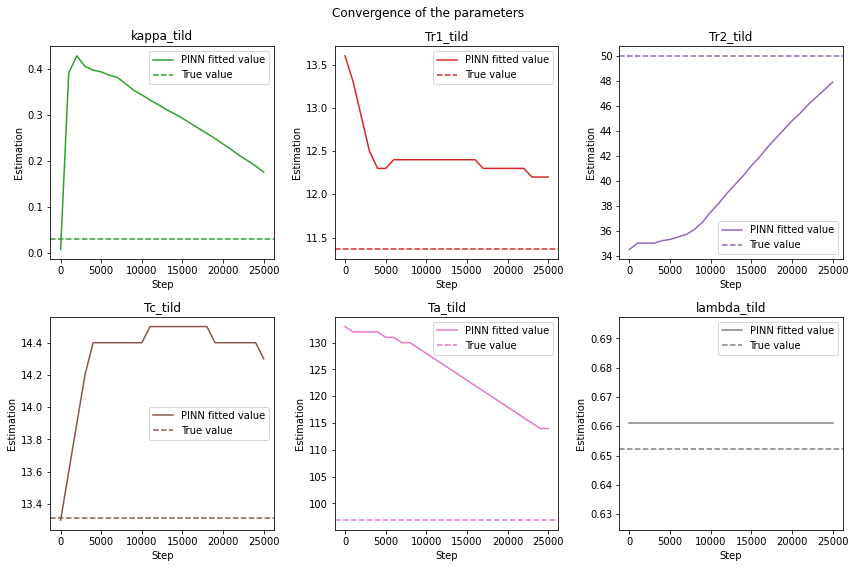

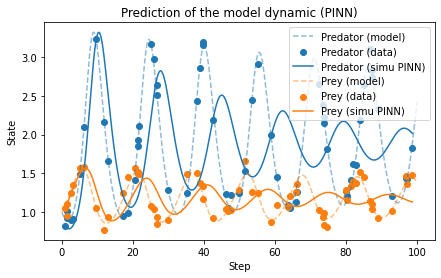

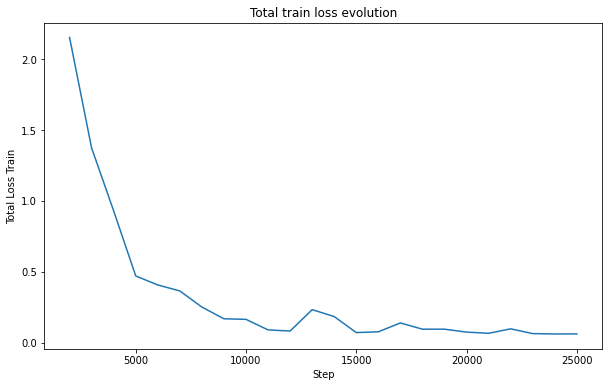

In [13]:
nn_architecture = [1, 128, 128, 128, 2]
lr = 1e-3
niter_weights=[25000]
weights = [[5, 5, 0.5, 0.5, 10, 10]] # [[PDE, BC, Data]]


# Create a directory for outputs
directory_path = "outputs/LV2_holing1-example/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '-all_params'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created at: {directory_path}")
else:
    print(f"Directory already exists at: {directory_path}")
path_for_export = os.path.join(directory_path, 'LV2_test')
print(f"Path for export: {path_for_export}")

# Adjust the PINN
model_pinn_LV2 = pinn(lv_model_2pop_derivatives, datagen_LV2, 
                      dimless_params_2pop_fitted, dimless_params_2pop_fixed)
model_pinn_LV2.get_train_data()
model_pinn_LV2.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                                   weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-loss_hist_train.dat")
# Plot the training
model_pinn_LV2.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_PINN.jpg")
model_pinn_LV2.plot_convergence(file_save_fig=path_for_export+"-param_convergence.jpg")
model_pinn_LV2.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                      file_save_fig=path_for_export+"-prediction_with_params.jpg", nb_p_t=10000)
model_pinn_LV2.plot_loss_history(file_save_fig=path_for_export+"-loss_history.jpg", elements_to_plot=["loss_train"], 
                                 start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_LV2.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                               file_save_gif=path_for_export+'-gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)
perf = model_pinn_LV2.performance()
print("Performance of the model:", perf)
model_pinn_LV2.save_possible_attr(filename_save=path_for_export+"-0_model_data.pkl")
with open(os.path.join(directory_path, "performances.pkl"), 'wb') as f:
    pickle.dump(perf, f)

## Loop on number of layers

In [14]:
nbr_hidden_layers = [1, 2, 3, 4, 5]
nbr_neur_in_hidden_layers = 128

lr = 1e-3
niter_weights=[25000]
weights = [[5, 5, 0.5, 0.5, 10, 10]] # [[PDE, BC, Data]]

directory_path = "outputs/architecture/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "-loop_depth_NN_LV2"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created at: {directory_path}")
else:
    print(f"Directory already exists at: {directory_path}")

all_models_lay = []
all_perf_lay = []
for n_layers in nbr_hidden_layers:
    nn_architecture = [1] + [nbr_neur_in_hidden_layers] * n_layers + [2]
    print( "\n\n     # # # # # # # # # # # # # # # # # # # # # ")
    print(f" # # # # # Architecture: {nn_architecture} # # # # #")
    print( "     # # # # # # # # # # # # # # # # # # # # # \n")
    path_for_export = os.path.join(directory_path, str(n_layers).zfill(2)+'layers')
    print(f"Path for export: {path_for_export}")

    # Adjust the PINN
    model_pinn_LV2_depth = pinn(lv_model_2pop_derivatives, datagen_LV2, 
                        dimless_params_2pop_fitted, dimless_params_2pop_fixed)
    model_pinn_LV2_depth.get_train_data()
    model_pinn_LV2_depth.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                                             weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-loss_hist_train.dat")
    # Plot the training
    model_pinn_LV2_depth.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_PINN.jpg")
    model_pinn_LV2_depth.plot_convergence(file_save_fig=path_for_export+"-param_convergence.jpg")
    model_pinn_LV2_depth.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                        file_save_fig=path_for_export+"-prediction_with_params.jpg", nb_p_t=10000)
    model_pinn_LV2_depth.plot_loss_history(file_save_fig=path_for_export+"-loss_history.jpg", elements_to_plot=["loss_train"], 
                                    start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
    model_pinn_LV2_depth.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                file_save_gif=path_for_export+'-gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)
    plt.close('all')
    all_perf_lay.append(model_pinn_LV2_depth.performance())
    print("Performance of the model with " + str(n_layers) + " layers:", all_perf_lay[-1])
    model_pinn_LV2_depth.save_possible_attr(filename_save=path_for_export+"-0_model_data.pkl")
    all_models_lay.append(model_pinn_LV2_depth)
with open(os.path.join(directory_path, "all_performances.pkl"), 'wb') as f:
    pickle.dump(all_perf_lay, f)
# with open(os.path.join(directory_path, "all_performances.pkl"), 'rb') as f:
#     all_perf_lay_import = pickle.load(f)

Directory created at: outputs/architecture/20240304_001605-loop_depth_NN_LV2


     # # # # # # # # # # # # # # # # # # # # # 
 # # # # # Architecture: [1, 128, 2] # # # # #
     # # # # # # # # # # # # # # # # # # # # # 

Path for export: outputs/architecture/20240304_001605-loop_depth_NN_LV2\01layers
- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild
Fixed parameters:  func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.042217 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.868607 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.19e+03, 4.25e+01, 4.90e-01, 5.81e-01, 2.05e+03, 1.36e+01]    [1.19e+03, 4.25e+01, 4.90e-01, 5.81e-01, 2.05e+03, 1.36e+01]    []  
1000      [1.29e-01, 3.27e-02, 1.37e-06, 4.76e-05, 4.30e+00, 6.06e-01]    [1.29e-01, 3.27e-02, 1.37e-06, 4.76e-05, 4.30e+00, 6.06e-01]    []  
2000      [1.28e-01, 3.05e-03, 1.82e-03, 4.67e-04, 4.26e+00, 5.97e-01]    [1.28e-01, 3.05e-03, 1.82e-03, 4.67e-04, 4.26e+00, 5.97e-01]    []  
3000      [1.11e-01, 3.58e-03, 1.73e-03, 1.29e-04, 4.23e+00, 5.81e-01]    [1.11e-01, 3.58e-03, 1.73e-03, 1.29e-04, 4.23e+00, 5.81e-01]    []  
4000      [7.83e-02, 8.13e-03, 6.99e-07, 3.93e-04, 4.04e+00, 5.54e-01]    [7.83e-02, 8.13e-03, 6.99e-07, 3.93e-04, 4.04e+00, 5.54e-01]    []  
5000      [6.30e-02, 9.04e-03, 2.62e-04, 7.16e-04, 3.62e+00, 5.05e-01]    [6.30e-02, 9.04

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.845664 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.95e+02, 1.48e+00, 3.70e-01, 5.66e-01, 1.19e+02, 2.19e+01]    [2.95e+02, 1.48e+00, 3.70e-01, 5.66e-01, 1.19e+02, 2.19e+01]    []  
1000      [8.64e-02, 1.29e-02, 8.33e-05, 2.00e-03, 3.20e+00, 4.23e-01]    [8.64e-02, 1.29e-02, 8.33e-05, 2.00e-03, 3.20e+00, 4.23e-01]    []  
2000      [7.13e-02, 1.03e-02, 5.22e-04, 9.51e-04, 2.68e+00, 3.58e-01]    [7.13e-02, 1.03e-02, 5.22e-04, 9.51e-04, 2.68e+00, 3.58e-01]    []  
3000      [6.51e-02, 5.44e-03, 4.87e-04, 1.89e-04, 2.26e+00, 3.02e-01]    [6.51e-02, 5.44e-03, 4.87e-04, 1.89e-04, 2.26e+00, 3.02e-01]    []  
4000      [3.86e-02, 5.15e-03, 8.69e-04, 3.93e-05, 2.09e+00, 2.88e-01]    [3.86e-02, 5.15e-03, 8.69e-04, 3.93e-05, 2.09e+00, 2.88e-01]    []  
5000      [5.47e-02, 5.45e-03, 9.36e-04, 9.03e-07, 1.99e+00, 2.63e-01]    [5.47e-02, 5.45

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.093078 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.47e-01, 3.71e-01, 3.73e-01, 5.51e-01, 1.34e+02, 5.92e+00]    [8.47e-01, 3.71e-01, 3.73e-01, 5.51e-01, 1.34e+02, 5.92e+00]    []  
1000      [7.89e-02, 4.76e-02, 6.31e-04, 6.69e-04, 3.12e+00, 3.76e-01]    [7.89e-02, 4.76e-02, 6.31e-04, 6.69e-04, 3.12e+00, 3.76e-01]    []  
2000      [5.01e-02, 8.53e-03, 6.56e-04, 7.56e-05, 2.09e+00, 2.92e-01]    [5.01e-02, 8.53e-03, 6.56e-04, 7.56e-05, 2.09e+00, 2.92e-01]    []  
3000      [9.28e-02, 3.95e-03, 1.33e-03, 4.26e-05, 1.88e+00, 2.18e-01]    [9.28e-02, 3.95e-03, 1.33e-03, 4.26e-05, 1.88e+00, 2.18e-01]    []  
4000      [4.12e-02, 4.78e-03, 9.86e-04, 1.94e-05, 1.54e+00, 2.08e-01]    [4.12e-02, 4.78e-03, 9.86e-04, 1.94e-05, 1.54e+00, 2.08e-01]    []  
5000      [2.48e-02, 5.68e-03, 1.23e-03, 1.60e-05, 1.15e+00, 2.03e-01]    [2.48e-02, 5.68

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.252180 s

'compile' took 2.112172 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.35e+00, 6.04e-02, 3.45e-01, 5.50e-01, 6.72e+01, 2.18e+01]    [3.35e+00, 6.04e-02, 3.45e-01, 5.50e-01, 6.72e+01, 2.18e+01]    []  
1000      [5.47e-02, 4.53e-03, 5.71e-04, 5.98e-05, 2.78e+00, 3.28e-01]    [5.47e-02, 4.53e-03, 5.71e-04, 5.98e-05, 2.78e+00, 3.28e-01]    []  
2000      [3.58e-02, 5.63e-03, 1.07e-03, 3.90e-05, 8.99e-01, 1.89e-01]    [3.58e-02, 5.63e-03, 1.07e-03, 3.90e-05, 8.99e-01, 1.89e-01]    []  
3000      [4.01e-02, 6.97e-03, 1.15e-03, 3.21e-05, 1.16e-01, 6.99e-02]    [4.01e-02, 6.97e-03, 1.15e-03, 3.21e-05, 1.16e-01, 6.99e-02]    []  
4000      [1.66e-02, 8.33e-03, 1.27e-03, 4.40e-05, 6.25e-02, 4.82e-02]    [1.66e-02, 8.33e-03, 1.27e-03, 4.40e-05, 6.25e-02, 4.82e-02]    []  
5000      [2.53e-02, 8.49e-03, 1.46e-03, 4.00e-05, 8.27e-02, 4.7

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.254958 s

'compile' took 2.607562 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.92e+01, 1.70e+00, 3.40e-01, 5.41e-01, 2.20e+01, 5.34e+01]    [1.92e+01, 1.70e+00, 3.40e-01, 5.41e-01, 2.20e+01, 5.34e+01]    []  
1000      [5.62e-02, 1.22e-02, 6.75e-04, 1.33e-04, 1.93e+00, 2.74e-01]    [5.62e-02, 1.22e-02, 6.75e-04, 1.33e-04, 1.93e+00, 2.74e-01]    []  
2000      [2.51e-02, 5.33e-03, 1.02e-03, 1.69e-05, 1.15e+00, 1.86e-01]    [2.51e-02, 5.33e-03, 1.02e-03, 1.69e-05, 1.15e+00, 1.86e-01]    []  
3000      [2.02e-02, 6.00e-03, 1.12e-03, 3.67e-05, 3.16e-01, 1.23e-01]    [2.02e-02, 6.00e-03, 1.12e-03, 3.67e-05, 3.16e-01, 1.23e-01]    []  
4000      [1.10e-02, 7.21e-03, 1.39e-03, 5.82e-06, 6.81e-02, 4.38e-02]    [1.10e-02, 7.21e-03, 1.39e-03, 5.82e-06, 6.81e-02, 4.38e-02]    []  
5000      [9.93e-03, 7.74e-03, 1.37e-03, 2.96e-05, 3.24e-02, 3.6

In [15]:
# pinn_imp = pinn(file_import_pinn_data="outputs/architecture/20240303_202840-loop_depth_NN_LV2/02layers-0_model_data.pkl")
# path_for_export = "outputs/architecture/20240303_202840-loop_depth_NN_LV2/000-2lay-"

# # pinn_imp.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_PINN.jpg")
# pinn_imp.plot_convergence(file_save_fig=path_for_export+"-param_convergence.jpg")
# pinn_imp.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
#                                     file_save_fig=path_for_export+"-prediction_with_params.jpg", nb_p_t=10000)
# pinn_imp.plot_loss_history(file_save_fig=path_for_export+"-loss_history.jpg", elements_to_plot=["loss_train"], 
#                                 start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
# pinn_imp.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
#                             file_save_gif=path_for_export+'-gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)

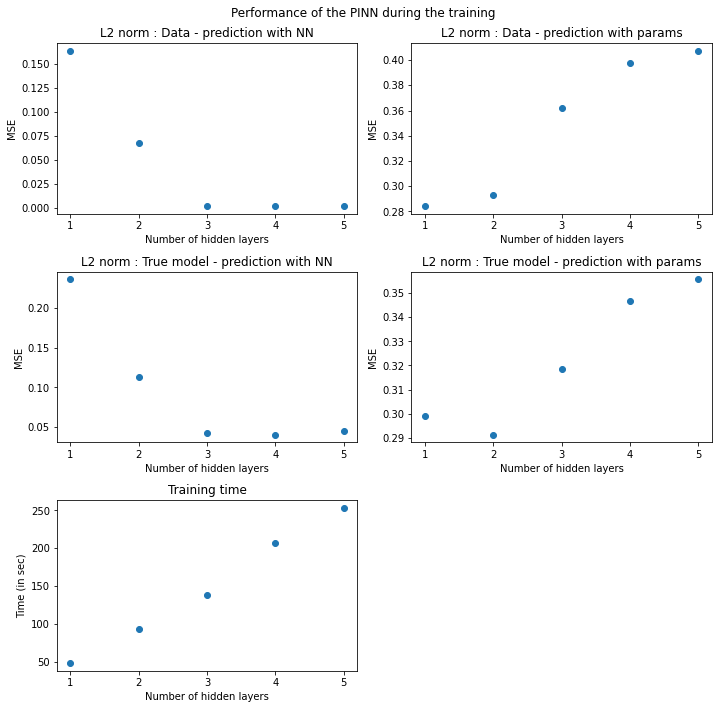

In [16]:
time_full_train_in_sec = []
MSE_data_NNpred = []
MSE_data_modelNNparams = []
MSE_true_NNpred = []
MSE_true_modelNNparams = []
for i in range(len(nbr_hidden_layers)):
    time_full_train_in_sec.append(all_perf_lay[i]["Training time (in sec):"])
    MSE_data_NNpred.append(all_perf_lay[i]["MSE data-prediction NN:"])
    MSE_data_modelNNparams.append(all_perf_lay[i]["MSE data-prediction model with fitted parameters:"])
    MSE_true_NNpred.append(all_perf_lay[i]["MSE true model-prediction NN:"])
    MSE_true_modelNNparams.append(all_perf_lay[i]["MSE true model-prediction model with fitted parameters:"])

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_hidden_layers, MSE_data_NNpred) ; plt.xlabel("Number of hidden layers") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with NN")
plt.subplot(3, 2, 2).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_hidden_layers, MSE_data_modelNNparams) ; plt.xlabel("Number of hidden layers") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with params")
plt.subplot(3, 2, 3).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_hidden_layers, MSE_true_NNpred) ; plt.xlabel("Number of hidden layers") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with NN")
plt.subplot(3, 2, 4).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_hidden_layers, MSE_true_modelNNparams) ; plt.xlabel("Number of hidden layers") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with params")
plt.subplot(3, 2, 5).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_hidden_layers, time_full_train_in_sec) ; plt.xlabel("Number of hidden layers") ; plt.ylabel("Time (in sec)") ; plt.title("Training time")
plt.suptitle("Performance of the PINN during the training")
plt.tight_layout()
plt.savefig(directory_path + "/0-performance_summary.jpg")
plt.show()

## Loop on the number of neurones per layers

In [17]:
nbr_hidden_layers = 3
nbr_neur_in_hidden_layers = [8, 16, 32, 64, 128, 256]

lr = 1e-3
niter_weights=[25000]
weights = [[5, 5, 0.5, 0.5, 10, 10]] # [[PDE, BC, Data]]

directory_path = "outputs/architecture/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "-loop_neurones_per_lay_NN_LV2"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created at: {directory_path}")
else:
    print(f"Directory already exists at: {directory_path}")

all_models_neur = []
all_perf_neur = []
for n_neur in nbr_neur_in_hidden_layers:
    nn_architecture = [1] + [n_neur] * nbr_hidden_layers + [2]
    print( "\n\n     # # # # # # # # # # # # # # # # # # # # # ")
    print(f" # # # # # Architecture: {nn_architecture} # # # # #")
    print( "     # # # # # # # # # # # # # # # # # # # # # \n")
    path_for_export = os.path.join(directory_path, str(n_neur).zfill(3)+'neurones')
    print(f"Path for export: {path_for_export}")

    # Adjust the PINN
    model_pinn_LV2_depth = pinn(lv_model_2pop_derivatives, datagen_LV2, 
                        dimless_params_2pop_fitted, dimless_params_2pop_fixed)
    model_pinn_LV2_depth.get_train_data()
    model_pinn_LV2_depth.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                                             weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-loss_hist_train.dat")
    # Plot the training
    model_pinn_LV2_depth.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_PINN.jpg")
    model_pinn_LV2_depth.plot_convergence(file_save_fig=path_for_export+"-param_convergence.jpg")
    model_pinn_LV2_depth.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                        file_save_fig=path_for_export+"-prediction_with_params.jpg", nb_p_t=10000)
    model_pinn_LV2_depth.plot_loss_history(file_save_fig=path_for_export+"-loss_history.jpg", elements_to_plot=["loss_train"], 
                                    start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
    model_pinn_LV2_depth.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                file_save_gif=path_for_export+'-gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)
    plt.close('all')
    all_perf_neur.append(model_pinn_LV2_depth.performance())
    print("Performance of the model with " + str(n_layers) + " layers:", all_perf_neur[-1])
    model_pinn_LV2_depth.save_possible_attr(filename_save=path_for_export+"-0_model_data.pkl")
    all_models_neur.append(model_pinn_LV2_depth)
with open(os.path.join(directory_path, "all_performances.pkl"), 'wb') as f:
    pickle.dump(all_perf_neur, f)
# with open(os.path.join(directory_path, "all_performances.pkl"), 'rb') as f:
#     all_perf_neur_import = pickle.load(f)

Directory created at: outputs/architecture/20240304_002935-loop_neurones_per_lay_NN_LV2


     # # # # # # # # # # # # # # # # # # # # # 
 # # # # # Architecture: [1, 8, 8, 8, 2] # # # # #
     # # # # # # # # # # # # # # # # # # # # # 

Path for export: outputs/architecture/20240304_002935-loop_neurones_per_lay_NN_LV2\008neurones
- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild
Fixed parameters:  func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 8, 8, 8, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.094981 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.438711 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.63e+02, 2.58e+01, 3.95e-01, 5.82e-01, 5.55e+02, 3.35e+01]    [6.63e+02, 2.58e+01, 3.95e-01, 5.82e-01, 5.55e+02, 3.35e+01]    []  
1000      [1.26e-01, 6.26e-02, 3.21e-03, 4.88e-03, 4.33e+00, 5.96e-01]    [1.26e-01, 6.26e-02, 3.21e-03, 4.88e-03, 4.33e+00, 5.96e-01]    []  
2000      [1.09e-01, 1.38e-02, 6.73e-04, 2.61e-04, 3.76e+00, 5.74e-01]    [1.09e-01, 1.38e-02, 6.73e-04, 2.61e-04, 3.76e+00, 5.74e-01]    []  
3000      [1.07e-01, 4.04e-03, 2.04e-04, 1.98e-04, 3.39e+00, 4.77e-01]    [1.07e-01, 4.04e-03, 2.04e-04, 1.98e-04, 3.39e+00, 4.77e-01]    []  
4000      [6.44e-02, 3.55e-03, 6.09e-04, 7.35e-06, 3.27e+00, 4.43e-01]    [6.44e-02, 3.55e-03, 6.09e-04, 7.35e-06, 3.27e+00, 4.43e-01]    []  
5000      [2.10e-02, 5.40e-03, 8.40e-04, 2.72e-05, 3.22e+00, 3.63e-01]    [2.10e-02, 5.40

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.749199 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.00e+03, 9.24e+01, 3.56e-01, 5.64e-01, 4.12e+02, 2.52e+02]    [3.00e+03, 9.24e+01, 3.56e-01, 5.64e-01, 4.12e+02, 2.52e+02]    []  
1000      [1.16e-01, 1.01e-01, 2.11e-05, 2.22e-03, 4.14e+00, 5.86e-01]    [1.16e-01, 1.01e-01, 2.11e-05, 2.22e-03, 4.14e+00, 5.86e-01]    []  
2000      [1.14e-01, 8.94e-02, 4.20e-04, 8.16e-04, 3.36e+00, 5.08e-01]    [1.14e-01, 8.94e-02, 4.20e-04, 8.16e-04, 3.36e+00, 5.08e-01]    []  
3000      [7.97e-02, 7.01e-02, 5.40e-04, 5.00e-04, 3.19e+00, 4.28e-01]    [7.97e-02, 7.01e-02, 5.40e-04, 5.00e-04, 3.19e+00, 4.28e-01]    []  
4000      [7.37e-02, 4.39e-02, 5.58e-04, 3.50e-04, 2.99e+00, 3.67e-01]    [7.37e-02, 4.39e-02, 5.58e-04, 3.50e-04, 2.99e+00, 3.67e-01]    []  
5000      [6.52e-02, 1.82e-02, 7.37e-04, 1.11e-04, 2.69e+00, 3.31e-01]    [6.52e-02, 1.82

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.579434 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.00e+01, 5.82e+00, 3.48e-01, 5.48e-01, 2.64e+02, 1.10e+01]    [7.00e+01, 5.82e+00, 3.48e-01, 5.48e-01, 2.64e+02, 1.10e+01]    []  
1000      [8.58e-02, 1.00e-02, 3.77e-04, 9.52e-04, 3.56e+00, 4.85e-01]    [8.58e-02, 1.00e-02, 3.77e-04, 9.52e-04, 3.56e+00, 4.85e-01]    []  
2000      [3.51e-02, 7.44e-03, 6.87e-04, 2.48e-05, 3.15e+00, 3.40e-01]    [3.51e-02, 7.44e-03, 6.87e-04, 2.48e-05, 3.15e+00, 3.40e-01]    []  
3000      [1.53e-02, 6.46e-03, 1.09e-03, 4.83e-05, 3.12e+00, 3.15e-01]    [1.53e-02, 6.46e-03, 1.09e-03, 4.83e-05, 3.12e+00, 3.15e-01]    []  
4000      [4.86e-02, 7.34e-03, 1.47e-03, 8.37e-05, 2.25e+00, 3.08e-01]    [4.86e-02, 7.34e-03, 1.47e-03, 8.37e-05, 2.25e+00, 3.08e-01]    []  
5000      [2.68e-02, 4.37e-03, 1.29e-03, 2.89e-05, 1.85e+00, 2.11e-01]    [2.68e-02, 4.37

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.755506 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.40e+02, 9.65e-01, 3.14e-01, 5.58e-01, 9.20e+01, 1.18e+02]    [9.40e+02, 9.65e-01, 3.14e-01, 5.58e-01, 9.20e+01, 1.18e+02]    []  
1000      [8.74e-02, 7.30e-02, 6.73e-04, 1.55e-03, 3.19e+00, 4.33e-01]    [8.74e-02, 7.30e-02, 6.73e-04, 1.55e-03, 3.19e+00, 4.33e-01]    []  
2000      [1.03e-01, 2.08e-02, 6.38e-04, 2.60e-04, 2.25e+00, 3.58e-01]    [1.03e-01, 2.08e-02, 6.38e-04, 2.60e-04, 2.25e+00, 3.58e-01]    []  
3000      [5.94e-02, 6.07e-03, 5.36e-04, 8.48e-05, 2.02e+00, 3.03e-01]    [5.94e-02, 6.07e-03, 5.36e-04, 8.48e-05, 2.02e+00, 3.03e-01]    []  
4000      [4.35e-02, 3.86e-03, 9.48e-04, 3.27e-05, 1.92e+00, 2.54e-01]    [4.35e-02, 3.86e-03, 9.48e-04, 3.27e-05, 1.92e+00, 2.54e-01]    []  
5000      [3.06e-02, 4.32e-03, 8.84e-04, 2.36e-05, 1.73e+00, 2.18e-01]    [3.06e-02, 4.32

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.769115 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.24e+02, 3.24e-01, 3.34e-01, 5.38e-01, 1.75e+01, 7.95e+01]    [2.24e+02, 3.24e-01, 3.34e-01, 5.38e-01, 1.75e+01, 7.95e+01]    []  
1000      [7.60e-02, 3.95e-02, 6.74e-04, 6.02e-04, 3.13e+00, 3.81e-01]    [7.60e-02, 3.95e-02, 6.74e-04, 6.02e-04, 3.13e+00, 3.81e-01]    []  
2000      [4.44e-02, 4.25e-03, 1.03e-03, 6.15e-05, 2.03e+00, 2.92e-01]    [4.44e-02, 4.25e-03, 1.03e-03, 6.15e-05, 2.03e+00, 2.92e-01]    []  
3000      [8.86e-02, 4.28e-03, 1.10e-03, 6.11e-05, 2.04e+00, 4.44e-01]    [8.86e-02, 4.28e-03, 1.10e-03, 6.11e-05, 2.04e+00, 4.44e-01]    []  
4000      [2.97e-02, 3.81e-03, 1.16e-03, 2.46e-05, 1.87e+00, 2.54e-01]    [2.97e-02, 3.81e-03, 1.16e-03, 2.46e-05, 1.87e+00, 2.54e-01]    []  
5000      [2.73e-02, 6.16e-03, 1.20e-03, 1.49e-05, 1.34e+00, 2.24e-01]    [2.73e-02, 6.16

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.139123 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.37e+02, 5.41e+01, 3.55e-01, 5.39e-01, 1.10e+02, 6.81e+02]    [8.37e+02, 5.41e+01, 3.55e-01, 5.39e-01, 1.10e+02, 6.81e+02]    []  
1000      [9.42e-02, 1.22e-01, 8.73e-04, 1.62e-03, 3.11e+00, 4.22e-01]    [9.42e-02, 1.22e-01, 8.73e-04, 1.62e-03, 3.11e+00, 4.22e-01]    []  
2000      [6.92e-02, 9.95e-02, 4.04e-04, 8.13e-04, 2.20e+00, 4.32e-01]    [6.92e-02, 9.95e-02, 4.04e-04, 8.13e-04, 2.20e+00, 4.32e-01]    []  
3000      [1.90e-01, 7.97e-02, 3.48e-04, 5.90e-04, 2.04e+00, 2.90e-01]    [1.90e-01, 7.97e-02, 3.48e-04, 5.90e-04, 2.04e+00, 2.90e-01]    []  
4000      [3.14e-01, 4.95e-02, 3.84e-04, 3.15e-04, 2.01e+00, 2.58e-01]    [3.14e-01, 4.95e-02, 3.84e-04, 3.15e-04, 2.01e+00, 2.58e-01]    []  
5000      [6.99e-02, 2.58e-02, 3.53e-04, 2.67e-04, 1.93e+00, 2.75e-01]    [6.99e-02, 2.58

In [18]:
time_full_train_in_sec = []
MSE_data_NNpred = []
MSE_data_modelNNparams = []
MSE_true_NNpred = []
MSE_true_modelNNparams = []
for i in range(len(nbr_neur_in_hidden_layers)):
    time_full_train_in_sec.append(all_perf_neur[i]["Training time (in sec):"])
    MSE_data_NNpred.append(all_perf_neur[i]["MSE data-prediction NN:"])
    MSE_data_modelNNparams.append(all_perf_neur[i]["MSE data-prediction model with fitted parameters:"])
    MSE_true_NNpred.append(all_perf_neur[i]["MSE true model-prediction NN:"])
    MSE_true_modelNNparams.append(all_perf_neur[i]["MSE true model-prediction model with fitted parameters:"])

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_neur_in_hidden_layers, MSE_data_NNpred) ; plt.xlabel("Number of neurones per layer") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with NN")
plt.subplot(3, 2, 2).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_neur_in_hidden_layers, MSE_data_modelNNparams) ; plt.xlabel("Number of neurones per layer") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with params")
plt.subplot(3, 2, 3).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_neur_in_hidden_layers, MSE_true_NNpred) ; plt.xlabel("Number of neurones per layer") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with NN")
plt.subplot(3, 2, 4).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_neur_in_hidden_layers, MSE_true_modelNNparams) ; plt.xlabel("Number of neurones per layer") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with params")
plt.subplot(3, 2, 5).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(nbr_neur_in_hidden_layers, time_full_train_in_sec) ; plt.xlabel("Number of neurones per layer") ; plt.ylabel("Time (in sec)") ; plt.title("Training time")
plt.suptitle("Performance of the PINN during the training")
plt.tight_layout()
plt.savefig(directory_path + "/0-performance_summary.jpg")
plt.show()

## Comparaison scipy

In [19]:
import utils.scipy_fitting as sf

directory_path = "outputs/LV2_holing1-scipy/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created at: {directory_path}")
else:
    print(f"Directory already exists at: {directory_path}")
path_for_export = os.path.join(directory_path, 'LV2_sci')
print(f"Path for export: {path_for_export}")



scipy_solver_LV2 = sf.scipy_fitting(lv_model_2pop_derivatives, datagen_LV2)
scipy_solver_LV2.get_train_data(new_gen_data=False, permissible_range=[0, np.inf], default_value=0)
t_rebuild, state_rebuild = scipy_solver_LV2.predict(params0=dimless_params_2pop_fitted, X_0=X_ini, fixed_params=dimless_params_2pop_fixed)

scipy_solver_LV2.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_scipy.jpg")

scipy_perf = scipy_solver_LV2.performance()
print("Performance of the model:", scipy_perf)
with open(path_for_export + "-performances.pkl", 'wb') as f:
    pickle.dump(scipy_perf, f)

Directory created at: outputs/LV2_holing1-scipy/20240304_004241
Path for export: outputs/LV2_holing1-scipy/20240304_004241\LV2_sci
We will use the same t_samples for all states for the curve_fit method
Prediction with curve_fit method (common t_samples)


c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\scipy_fitting.py:91: OptimizeWarning: Covariance of the parameters could not be estimated
  params_fit, info_fit = curve_fit(self.integration_model, data1_for_fit, data2_for_fit, p0=p0)


Performance of the model: {'True parameters fixed:': {'func_resp': 'holling1', 'Tref': 10}, 'True parameters fitted:': {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0, 'Tc_tild': 13.31033307777494, 'Ta_tild': 96.89922480620156, 'lambda_tild': 0.6521666666666667}, 'Final fitted parameters:': {'kappa_tild': 0.007010913802981628, 'Tr1_tild': 11.133204405675338, 'Tr2_tild': 52.628532719426204, 'Tc_tild': 13.391078191207924, 'Ta_tild': 99.55720587222211, 'lambda_tild': 0.660831246046354}, 'Training time (in sec):': 1.425321340560913, 'MSE data-prediction scipy:': 0.1451611380612531, 'MSE true model-prediction scipy:': 0.03197571532166699}
